In [2]:
import os 
import numpy
from scipy import integrate, linalg
from matplotlib import pyplot 
%matplotlib inline

In [3]:
#load geometry from data file 
naca_filepath = os.path.join('naca0012.dat')
with open(naca_filepath, 'r') as infile:
    x, y = numpy.loadtxt(infile, dtype=float, unpack=True)

(-0.1, 0.1)

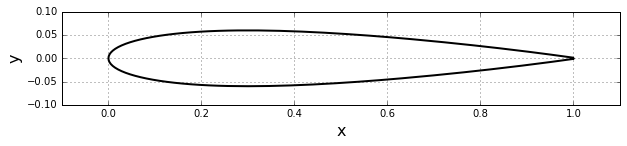

In [4]:
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1)

In [5]:
class Panel:
    
    def __init__(self, xa, ya, xb, yb):
        
        self.xa, self.ya = xa, ya #panel start 
        self.xb, self.yb = xb, yb #panel end
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2 #panel center 
        self.length = numpy.sqrt((xb-xa)**2 + (yb-ya)**2) #panel length
        
        #angle between x axis and panel's normal - orientation 
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
            
        #panel location 
        if self.beta <= numpy.pi:
            self.loc = 'upper' #upper surface
        else:
            self.loc = 'lower' #lower surface 
            
        self.sigma = 0.0 #strength of source
        self.vt = 0.0 #tangential velocity 
        self.cp = 0.0 #pressure coeff

In [14]:
def define_panels(x, y, N=40):
    """discretizes geometry into panels using cosine method"""
    
    R = (x.max()-x.min())/2.0 #circle radius 
    x_center = (x.max()+x.min())/2.0 #x coordinate of circle center
    
    theta = numpy.linspace(0.0, 2.0*numpy.pi, N+1) #array of angles 
    x_circle = x_center + R*numpy.cos(theta) #x coordinates of circle
    
    x_ends = numpy.copy(x_circle) #x coordinates of panels end-points
    y_ends = numpy.empty_like(x_ends) #y coordinates of panels end points
    
    #extend coordinates to consider closed surface
    x, y = numpy.append(x, x[0]), numpy.append(y, y[0])
    
    #compute y coordinates of end points by projection 
    I = 0 
    for i in range(N):
        while I < len(x)-1:
            if (x[I] <= x_ends[i] <= x[I+1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I+1]-y[I])/(x[I+1]-x[I])
        b = y[I+1] - a*x[I+1]
        y_ends[i] = a*x_ends[i] + b
        y_ends[N] = y_ends[0]
        
        
    #create panels 
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
        
    return panels

In [15]:
#discretize geometry into panels 
panels = define_panels(x, y, N=40)

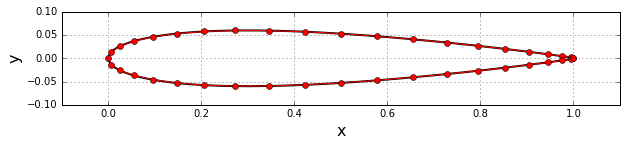

In [16]:
#plot discretized geometry 
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
           numpy.append([panel.ya for panel in panels], panels[0].ya), 
           linestyle='-', linewidth=1, marker='o', markersize=6, color='r')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

In [17]:
class Freestream:
    """Freestream conditions"""
    def __init__(self, u_inf=1.0, alpha=0.0):
        """Sets the freestream speed and angle (in degrees)"""
        
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 #degrees to radians

In [18]:
freestream = Freestream(u_inf=1.0, alpha=4.0)

In [21]:
def integral(x, y, panel, dxdk, dydk):
    """Evaluates the contribution from a panel at a given point"""
    
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                 +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
               / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
        
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [22]:
def source_contribution_normal(panels):
    """Builds the source contribution matrix for the normal velocity"""
    
    A = numpy.empty((panels.size, panels.size), dtype=float)
    #source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    #source contribution on a panel from others 
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] - 0.5/numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                 panel_j, 
                                                 numpy.cos(panel_i.beta), 
                                                 numpy.sin(panel_i.beta))
    return A

In [23]:
def vortex_contribution_normal(panels):
    """Builds the vortex contribution matrix for the normal velocity"""
    
    A = numpy.empty((panels.size, panels.size), dtype=float)
    #vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    #vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j, 
                                                numpy.sin(panel_i.beta), 
                                                -numpy.cos(panel_i.beta))
    return A

In [24]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

In [25]:
def kutta_condition(A_source, B_vortex):
    """Builds the Kutta condition array"""
    
    b = numpy.empty(A_source.shape[0]+1, dtype=float)
    #matrix of source contribution on tangential velocity 
    #is the same than 
    #matrix of vortex contribution on normal velocity
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    #matrix of vortex contribution on tangential velocity 
    #is the opposite of 
    #matrix of source contribution on normal velocity 
    b[-1] = -numpy.sum(A_source[0, :] + A_source[-1, :])
    return b

In [26]:
def build_singularity_matrix(A_source, B_vortex):
    """Builds the left hand side matrix of the system 
    arising from source and vortex contributions"""
    
    A = numpy.empty((A_source.shape[0]+1, A_source.shape[1]+1), dtype=float)
    #source contribution matrix 
    A[:-1, :-1] = A_source
    #vortex contribution array 
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    #Kutta condition array 
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

In [27]:
def build_freestream_rhs(panels, freestream):
    """Builds the RHS of the system 
    arising from the freestream contribution"""
    
    b = numpy.empty(panels.size+1, dtype=float)
    #freestream contribution on each panel 
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    #freestream contribution on the Kutta condition 
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                              + numpy.sin(freestream.alpha-panels[-1].beta) )
    return b

In [28]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)

In [30]:
#solve for the singularity strengths
strengths = numpy.linalg.solve(A, b)

#store source strength on each panel 
for i, panel in enumerate(panels):
    panel.sigma = strengths[i]
    
#store circulation density 
gamma = strengths[-1]

In [31]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """Computes the tangential surface velocity"""
    
    A = numpy.empty((panels.size, panels.size+1), dtype=float)
    #matrix of source contribution on tangential velocity
    #is the same than 
    #matrix of vortex contribution on normal velocity 
    A[:,:-1] = B_vortex
    #matrix of vortex contribution on tangential velocity 
    #is the opposite of 
    #matrix of source contribution on normal velocity 
    A[:, -1] = -numpy.sum(A_source, axis=1)
    #freestream contribution 
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta
                                     for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [33]:
#tangential velocity at each panel center
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)

In [34]:
def compute_pressure_coefficient(panels, freestream):
    """Computes the surface pressure coefficients"""
    
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [35]:
#surface pressure coefficient 
compute_pressure_coefficient(panels, freestream)